# Assessment 2: Argumentation

In [26]:
from itertools import chain, combinations
import networkx as nx
G = nx.DiGraph()

In [27]:
#edges = [('a', 'b'), ('b', 'a')]
edges = [('a', 'b'), ('c', 'b'), ('c', 'd'), ('d', 'c'), ('d', 'e'), ('e', 'e')]
G.add_edges_from(edges)

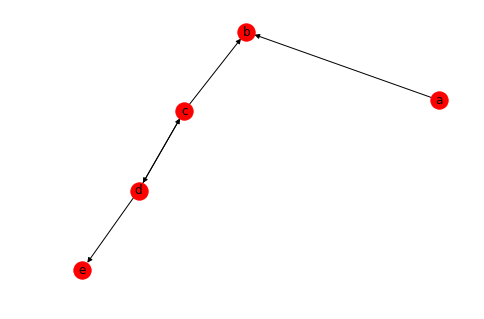

In [28]:
import matplotlib.pyplot as plt
nx.draw(G,pos=nx.kamada_kawai_layout(G), with_labels = True)

In [29]:
def is_in(af,argument):
    for (attacker,_) in af.in_edges(argument):
        if af.nodes[attacker]['labelling']!="out":
            return False
    return True

def is_out(af,argument):
    in_size = 0
    for (attacker,_) in af.in_edges(argument):
        if af.nodes[attacker]['labelling']=="in":
            in_size +=1
    
    if in_size==0:
        return False
    else:
        return True
    
def is_undec(af,argument):
    in_size = 0
    out_size = 0
    undec_size = 0
    for (attacker,_) in af.in_edges(argument):
        if af.nodes[attacker]['labelling']=="in":
            in_size +=1
        elif af.nodes[attacker]['labelling']=="out":
            out_size +=1
        else:
            undec_size +=1
    
    if (in_size==0 and undec_size!=0):
        return True
    else:
        return False

def lab_is_admissible(af, labelling):
    nx.set_node_attributes(af, labelling, 'labelling')
    for node in af.nodes:
        if af.nodes[node]['labelling']=="in":
            if not is_in(af, node):
                return False
        if af.nodes[node]['labelling']=="out":
            if not is_out(af, node):
                return False
    return True

In [30]:
labels =[{'a': 'in', 'b': 'in'},
         {'a': 'in', 'b': 'out'},
         {'a': 'in', 'b': 'undec'},
         {'a': 'out', 'b': 'in'},
         {'a': 'out', 'b': 'out'},
         {'a': 'out', 'b': 'undec'},
         {'a': 'undec', 'b': 'in'},
         {'a': 'undec', 'b': 'out'},
         {'a': 'undec', 'b': 'undec'}]

In [31]:
nx.set_node_attributes(G, {'a': 'in', 'e': 'out', 'b': 'out', 'd': 'undec', 'c': 'undec'}, 'labelling')

In [32]:
def powerset(base_set):
    """ modified from pydoc’s itertools recipe"""
    from itertools import chain, combinations
    base_list = list(base_set)
    combo_list = [combinations(base_list, r) for r in range(len(base_set)+1)]
    
    powerset = set([])
    for ll in combo_list:
        list_of_frozensets = list(map(frozenset, map(list, ll)))
        set_of_frozensets = set(list_of_frozensets)
        powerset = powerset.union(set_of_frozensets)
    return powerset

In [33]:
def generateLabellings(args):
    output=[]
    for ina in powerset(args):
        for outa in powerset(args-ina):
            output.append([ina,outa,(args-ina)-outa])
    return output

In [34]:
def possible_labellings(args):
    #gives all possible labellings for a set of arguments
    labellings = []
    for i in generateLabellings(args):
        labelling = {}
        for index, j in enumerate(i):
            if len(j) > 0:
                for k in j:
                    if index == 0:
                        labelling[k] = 'in'
                    elif index == 1:
                        labelling[k] = 'out'
                    else:
                        labelling[k] = 'undec'
        labellings.append(labelling)
    return labellings

# Task1

This part uses the definition as given in section 2.2 of the book **Elements of Argumentation, MIT Press, Philippe Besnard and Anthony Hunter**. Following the same methodology, we move from the admissible sets to the stable semantics. The implementation code below can be summarised in the following functions:
* admissible_sets(_) for all the admissible sets
* complete_extension(_) for the complete semantics
* grounded_extension(_) to get the grounded extension
* preferred_extension(_) in order to retrieve the preferred extension
* stable_extension(_) for the stable semantics

In [35]:
def args_plus(af, args):
    #takes an argumentation graph and a set of arguments
    #outputs all the set of all arguments that it attacks
    args_plus = set()
    for argument in args:
        for (_, attacked) in af.out_edges(argument):
            args_plus.add(attacked)
    return args_plus

def args_minus(af, args):
    #takes an argumentation graph and a set of arguments
    #outputs all the set of all arguments that attack it
    args_minus = set()
    for argument in args:
        for (attacker, _) in af.in_edges(argument):
            args_minus.add(attacker)
    return args_minus

def is_conflictfree(af, args):
    #af = argumentation graph, args = set of arguments
    #tells in a set of arguments is conflict-free
    if len(args.intersection(args_plus(af, args)))==0:
        return True
    else:
        return False
    
def is_defendedby(af, args, arg):
    #outputs True if arg is defended by args in the af argumentation framework
    arg_minus = args_minus(af, arg)
    argsplus = args_plus(af, args)
    
    for att in arg_minus:
        if not {att}.issubset(argsplus):
            return False
    
    return True
    
    
def defends_itselem(af, args):
    #outputs True if args defends all its elements in the af argumentation framework
    for arg in args:
        if not is_defendedby(af, args, {arg}):
            return False
    return True

def defends_only_itselem(af, args):
    #outputs True if args only defends its elements in the af argumentation framework
    for arg in (af.nodes - args):
        if is_defendedby(af, args, {arg}):
            return False
        
    return True

def attacks_each_nonmember(af, args):
    #outputs true if args attacks each argument not in args in the af argumentation framework
    if args_plus(af, args)==(af.nodes - args):
        return True
    else:
        return False
        
def admissible_sets(af):
    #returns the admissible sets
    admissible_sets = set()
    
    for label in possible_labellings(af.nodes):
        myset = frozenset([elem for elem in label.keys() if label[elem]=="in"])
        if lab_is_admissible(af, label) and  is_conflictfree(af, myset) and defends_itselem(af, myset):
            admissible_sets.add(myset)
    return admissible_sets

def complete_extension(af):
    #calculate the complete extension
    complete_extension = set()
        
    for admissible_set in admissible_sets(af):
        if defends_only_itselem(af, admissible_set):
            complete_extension.add(admissible_set)
            
    return complete_extension

def grounded_extension(af):
    #determines the grounded extension
    args = complete_extension(af)
        
    for elemi in args:
        grounded_extension = elemi
        for elemj in args:
            if elemi != elemj:
                grounded_extension = grounded_extension.intersection(elemj)
        
        return grounded_extension

def exists_inclusion(args):
    #returns True if a set is a subset of another in a set of sets
    for i in args:
        for j in args:
            if i!=j and i.issubset(j):
                return True
    return False

def preferred_extension(af):
    #for the preferred extension
    preferred_extension = complete_extension(af)
    
    while exists_inclusion(preferred_extension):
        for i in preferred_extension.copy():
            for j in preferred_extension.copy():
                if i!=j and i.issubset(j):
                    preferred_extension.discard(i)
                    continue
        
    return preferred_extension

def stable_extension(af):
    #computes the stable extension
    stable_extension = set()
    
    for elem in  preferred_extension(af):
        if attacks_each_nonmember(af, elem):
            stable_extension.add(elem)
        
    return stable_extension

## Example: stable extension
The code runs exponentially in the number of arguments because evaluating all the possible labelling is of 2^{args} order of magnitude intensive

In [36]:
stable_extension(G)

{frozenset({'a', 'd'})}

# Task2

This part is about using the characteristic function to compute the grounded, complete, preferred(skeptical and credulous) and stable semantics. The difference between the first task is that task1 was using labellings and heavily reliant on inter-argument attacks. Code created using definitions in the section 2.4 of the book **Elements of Argumentation, MIT Press, Philippe Besnard and Anthony Hunter**. Under are implemented some most relevant functions necessary for argumentation framework reasoning:
* caracteristic_function(__,__) which takes an argumentation framework and a set of arguments and gives all the arguments that this set defends
* nw_grounded(_) computes the grounded extension
* nw_admissible_sets(_) gives the admissible sets
* nw_complete_extension(_) outputs the complete extension
* nw_preferred_extension(_) returns the preferred extension
* nw_credulous_preferred_extension(_) determines the credulous preferred extension
* nw_skeptical_preferred_extension(_) computes the skeptical preferred extension
* nw_stable_extension(_) finds the stable extension

In [37]:
def caracteristic_function(af, args):
    #an implementation of the characteristic function
    result = set()
    
    for node in af.nodes:
        if is_defendedby(af, args, {node}):
            result.add(node)
    
    return result

def nw_grounded_extension(af):
    #grounded extension based on characteristic function
    args = set()
    
    while caracteristic_function(af, args) != args:
        args = caracteristic_function(af, args)
        
    return args

def nw_admissible_sets(af):
    #admissible sets using characteristic function
    admissible_sets = set()
    for aset in powerset(af.nodes):
        if aset.issubset(caracteristic_function(af, aset)) and is_conflictfree(af, aset):
            admissible_sets.add(aset)
            
    return admissible_sets

def nw_complete_extension(af):
    #complete extension using characteristic function
    complete_extension = set()
    for aset in nw_admissible_sets(af):
        if aset == caracteristic_function(af, aset):
            complete_extension.add(aset)
            
    return complete_extension

def nw_preferred_extension(af):
    #preferred extension
    preferred_extension = nw_complete_extension(af)
    
    while exists_inclusion(preferred_extension):
        for i in preferred_extension.copy():
            for j in preferred_extension.copy():
                if i!=j and i.issubset(j):
                    preferred_extension.discard(i)
                    continue
        
    return preferred_extension

def nw_credulous_preferred_extension(af):
    #credulous preferred extension
    credulous_preferred_extension = set()
    
    for preferred_set in nw_preferred_extension(af):
        credulous_preferred_extension = credulous_preferred_extension.union(preferred_set)
        
    return credulous_preferred_extension

def nw_skeptical_preferred_extension(af):
    #skeptical preferred extension
    preferred_extension = list(nw_preferred_extension(af))
    skeptical_preferred_extension = preferred_extension[0]
    
    for preferred_set in nw_preferred_extension(af):
        skeptical_preferred_extension = skeptical_preferred_extension.intersection(preferred_set)
        
    return skeptical_preferred_extension

def nw_stable_extension(af):
    #stable extension
    stable_extension = set()
    
    for elem in nw_preferred_extension(af):
        if attacks_each_nonmember(af, elem):
            stable_extension.add(elem)
        
    return stable_extension

## Example: grounded semantics

In [38]:
nw_grounded_extension(G)

{'a'}

# Task3

The function all_arguments(rules) has been implemented as required in the assessment. It creates "argument" objects from a set of rules.

In [39]:
class Rule:
    def __init__(self,premises,conclusion,defeasible):
        self.premises=premises
        self.conclusion=conclusion
        self.defeasible=defeasible
        
    def applicable(self,kb):
        """ returns true if all the premises hold, i.e., if the rule can be applied"""
        return self.premises.issubset(kb)

In [40]:
class Argument:
    def __init__(self,subarguments,toprule):
        """ subarguments are the subarguments used to generate this argument. toprule
        is the rule applied to move from subarguments to the current argument. A rule
        of the form -> a has no subarguments."""
        self.subarguments=subarguments# + self #note an argument is its own subargument
        self.toprule=toprule

In [41]:
def SubArguments(setOfArguments, conclusion):
    #outputs all the subarguments of 
    
    result = set()
        
    for argument in setOfArguments:
        if argument.toprule.conclusion.issubset(conclusion):
            result.add(argument)
            
    return result

def argumentsConclusion(setOfArguments):
    #the conclusions of a set of arguments
    
    result = set()
        
    for argument in setOfArguments:
        result = result.union(argument.toprule.conclusion)
            
    return result

In [42]:
def argumentsConclusions(arguments):
    #the conclusions of a set of arguments
    conclusions = set()
    
    for argument in arguments:
        conclusions = conclusions.union(argument.toprule.conclusion)
        
    return conclusions

def oneCanFindArguments(rules, arguments):
    #returns True if other arguments can be created from an already existing set of arguments
    if len(rules) == 0:
        return False
    if len(arguments)==0:
        for rule in rules:
            if rule.applicable(arguments):
                return True
    else:
        for rule in rules:
            if rule.applicable(argumentsConclusions(arguments)):
                return True
            
    return False
        

def all_arguments(rules):
    #takes a set of rules and gives back all the possible arguments possible

    arguments = set()
    regles = rules
    
    while oneCanFindArguments(regles, arguments):
        regle_utilisee = set()
        for regle in regles:
            
            for argumentset in powerset(arguments):
                if regle.applicable(argumentsConclusions(argumentset)) and (len(regle.premises) == len(argumentset)):
                    toprule = regle
                    subarguments = argumentset
                    
                    arguments.add(Argument(subarguments,toprule))
                    
                    regle_utilisee.add(regle)
                    
        regles = regles - regle_utilisee
        
    return arguments

In [43]:
rule1 = Rule(premises=set(), conclusion={'a'}, defeasible=False)
rule2 = Rule(premises=set(), conclusion={'b'}, defeasible=False)
rule3 = Rule(premises={'a','b'}, conclusion={'c'}, defeasible=False)
rule4 = Rule(premises={'c'}, conclusion={'e'}, defeasible=True)
rule5 = Rule(premises=set(), conclusion={'-e'}, defeasible=True)
rule6 = Rule(premises={'a'}, conclusion={'b'}, defeasible=True)
#onearg = Argument(subarguments= None, toprule='->')

## Example: all arguments from rules

In [44]:
res = all_arguments(set([rule1, rule2, rule3, rule4, rule5]))
res = list(res); print(len(res))
print(rule1)
print(rule2)
print(rule3)
print(rule4)
print(rule5)
print("--------")
for arg in res:
    print(arg, '|',arg.subarguments,'|', arg.toprule,'|', arg.toprule.premises,'|', 
          arg.toprule.conclusion,'|', arg.toprule.defeasible)

5
--------
<__main__.Argument object at 0x7fb58005c208> | frozenset() | <__main__.Rule object at 0x7fb58014dd68> | set() | {'b'} | False
<__main__.Argument object at 0x7fb58005cf60> | frozenset() | <__main__.Rule object at 0x7fb58005cdd8> | set() | {'-e'} | True
<__main__.Argument object at 0x7fb58005c9b0> | frozenset({<__main__.Argument object at 0x7fb58005c208>, <__main__.Argument object at 0x7fb58005cbe0>}) | <__main__.Rule object at 0x7fb58005c780> | {'b', 'a'} | {'c'} | False
<__main__.Argument object at 0x7fb58005c3c8> | frozenset({<__main__.Argument object at 0x7fb58005c9b0>}) | <__main__.Rule object at 0x7fb58005ce48> | {'c'} | {'e'} | True
<__main__.Argument object at 0x7fb58005cbe0> | frozenset() | <__main__.Rule object at 0x7fb58014d940> | set() | {'a'} | False


In [45]:
def conflictingConclusions(conclusion1, conclusion2):
    #tells if two conclusions are in conflict
    return set(list(conclusion1)[0]).symmetric_difference(set(list(conclusion2)[0]))  == set('-')


def isDefeating(argument1, argument2):
    #returns True if two arguments attack each other
    if conflictingConclusions(argument1.toprule.conclusion, argument2.toprule.conclusion):
        return True
    
    if len(argument2.subarguments) != 0:
        for subArgument2 in argument2.subarguments:
            return isDefeating(argument1, subArgument2)
        
    return False

# Task4

The simple to_af(rules) takes a set of rules and outputs an argumentation framework. It builds upon the preceding method all_arguments(rules) and adds an edge to the defeated argument.

In [46]:
def to_af(rules):
    #takes a set of rules and outputs an argumentation framework
    arguments = list(all_arguments(rules))
    af = nx.DiGraph()
    af.add_nodes_from(arguments)
    
    for argument1 in arguments:
        for argument2 in arguments:
            if isDefeating(argument1, argument2):
                af.add_edge(argument1, argument2)
                
    return af

## Example: argumentation framework from rules

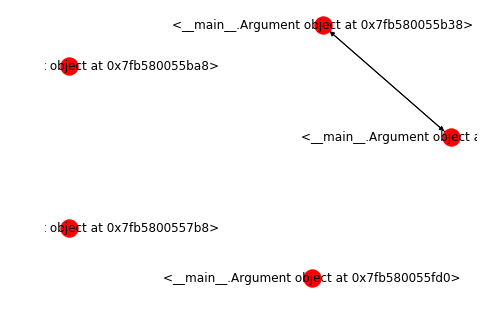

In [47]:
af = to_af(set([rule1, rule2, rule3, rule4, rule5]))
nx.draw(af,pos=nx.kamada_kawai_layout(af), with_labels = True)

# Task5

Finally, based on the paper **Martin Caminada, Sanjay Modgil and Nir Oren. ‘Preferences and Unrestricted Rebut’. In: COMMA. Vol. 266. Frontiers in Artificial Intelligence and Applications. IOS Press, 2014, pp. 209–220**, we materialise the concepts of the set of defeasible rules and how an argument is defined less preferred than another one based on either the elitist or democratic principle.

In [48]:
def defRules(argument):
    #takes an argument and
    #outputs the set of its defeasible rules
    result = set()
    if argument.toprule.defeasible:
        result.add(argument.toprule)
    
    for subarg in argument.subarguments:
        result.intersection(defRules(subarg))
        
    return result
    
    
def isLessPreferred(arg1, arg2, preferences, principle):
    #returns True if argument 1 (arg1) is less preferred than argument 2 (arg2) according to some preference principle
    if principle == 'elitist':
        for defrule in defRules(arg1):
            ens = set([(a,defrule) for a in defRules(arg2)])
            if ens.issubset(preferences):
                return True
    
    else:
        for defrule in defRules(arg2):
            ens = set([(defrule, a) for a in defRules(arg1)])
            if ens.issubset(preferences):
                return True

    return False

def extract_conclusions(rules,preferences,semantics,principle):
    #the end-to-end conclusion computation from rules, preference mechanism and chosen semantics
    af = to_af(rules)
    for node in af.nodes:
        for (attacker, _) in af.in_edges(node):
            if isLessPreferred(attacker, node, preferences, principle):
                af.remove_edge(attacker,node)
    
    conclusions = set()
    if semantics == 'grounded':
        extension = nw_grounded_extension(af)
    
    if semantics == 'stable':
        extension = nw_stable_extension(af)
    
    if semantics == 'skeptical preferred':
        extension = nw_skeptical_preferred_extension(af)
    
    if semantics == 'credulous preferred':
        extension = nw_credulous_preferred_extension(af)

    try:
        for aset in extension:
            conclusions = conclusions.union(argumentsConclusions(aset))
    except:
        conclusions = conclusions.union(argumentsConclusions(extension))
        
        return conclusions

## Example: end-to-end rules to conclusion system

In [49]:
extract_conclusions(rules=set([rule1, rule2, rule3, rule4, rule5]),preferences = (rule1, rule4),semantics="grounded",principle="elitist")

{'a', 'b', 'c'}

# References

Overall, the documents we referred to during the course of this assessment are listed below.
* **Elements of Argumentation, MIT Press, Philippe Besnard and Anthony Hunter**
* **Martin Caminada, Sanjay Modgil and Nir Oren. ‘Preferences and Unrestricted Rebut’. In: COMMA. Vol. 266. Frontiers in Artificial Intelligence and Applications. IOS Press, 2014, pp. 209–220**
* https://pdfs.semanticscholar.org/21a1/a88328f8e274816a70061666ee2ded6f8235.pdf
* https://users.cs.cf.ac.uk/CaminadaM/publications/KER-BaroniCaminadaGiacomin.pdf
* https://users.cs.cf.ac.uk/CaminadaM/publications/WU_studiesInLogic2010.pdf